In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
import seaborn as sb
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

import collections
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords

C:\Users\jiang\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
[nltk_data] Downloading package punkt to C:\Users\jiang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jiang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Clean

In [7]:
data = pd.read_csv("fake_job_postings.csv")

In [8]:
location = data["location"].str.split(",", expand= True, n= 2)
location.columns = ["country", "state", "city"]
data[["country", "state", "city"]] = location
data = data.drop(columns= "location")

In [9]:
salary = data["salary_range"].str.split("-", expand= True, n= 1)
data[["min_salary", "max_salary"]] = salary
data = data.drop(columns= "salary_range")

In [10]:
data = data.fillna("N/A")
data["state"] = data["state"].str.strip().apply(lambda x: "N/A" if x == '' else x)
data["country"] = data["country"].str.strip().apply(lambda x: "N/A" if x == '' else x)
data["city"] = data["city"].str.strip().apply(lambda x: "N/A" if x == '' else x)

In [11]:
for i in ["company_profile", "description", "requirements", "benefits"]:
    data[i] = data[i].str.lower()

In [12]:
data.isnull().sum()

job_id                 0
title                  0
department             0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
country                0
state                  0
city                   0
min_salary             0
max_salary             0
dtype: int64

In [14]:
data.head()

,job_id,title,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,...,required_experience,required_education,industry,function,fraudulent,country,state,city,min_salary,max_salary
0,1,Marketing Intern,Marketing,"we're food52, and we've created a groundbreaki...","food52, a fast-growing, james beard award-winn...",experience with content management systems a m...,n/a,0,1,0,...,Internship,N/A,N/A,Marketing,0,US,NY,New York,N/A,N/A
1,2,Customer Service - Cloud Video Production,Success,"90 seconds, the worlds cloud video production ...",organised - focused - vibrant - awesome!do you...,what we expect from you:your key responsibilit...,what you will get from usthrough being part of...,0,1,0,...,Not Applicable,N/A,Marketing and Advertising,Customer Service,0,NZ,N/A,Auckland,N/A,N/A
2,3,Commissioning Machinery Assistant (CMA),N/A,valor services provides workforce solutions th...,"our client, located in houston, is actively se...",implement pre-commissioning and commissioning ...,n/a,0,1,0,...,N/A,N/A,N/A,N/A,0,US,IA,Wever,N/A,N/A
3,4,Account Executive - Washington DC,Sales,our passion for improving quality of life thro...,the company: esri – environmental systems rese...,"education: bachelor’s or master’s in gis, busi...",our culture is anything but corporate—we have ...,0,1,0,...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US,DC,Washington,N/A,N/A
4,5,Bill Review Manager,N/A,spotsource solutions llc is a global human cap...,job title: itemization review managerlocation:...,qualifications:rn license in the state of texa...,full benefits offered,0,1,1,...,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US,FL,Fort Worth,N/A,N/A


## Explore

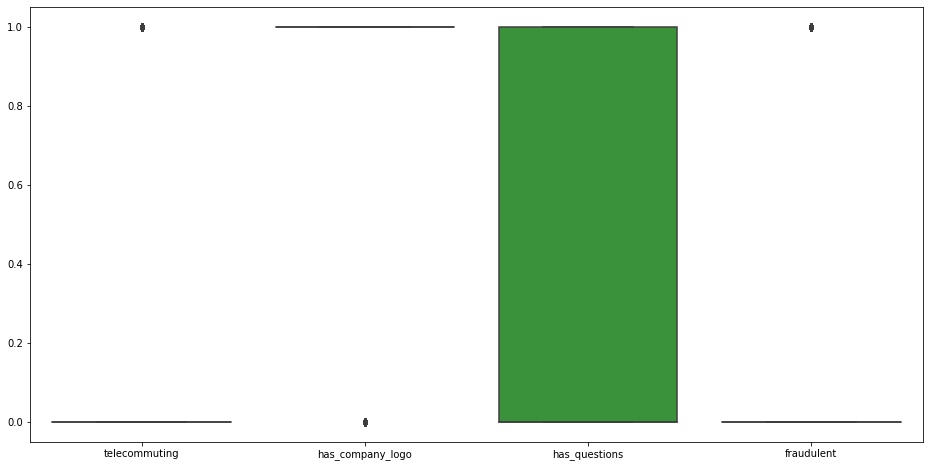

In [27]:
# check outliers
plt.figure(figsize = [16, 8])
sb.boxplot(data = data[['telecommuting','has_company_logo','has_questions','fraudulent', 'min_salary', 'max_salary']])
plt.show()

Text(0.5, 0, '\nFraud')

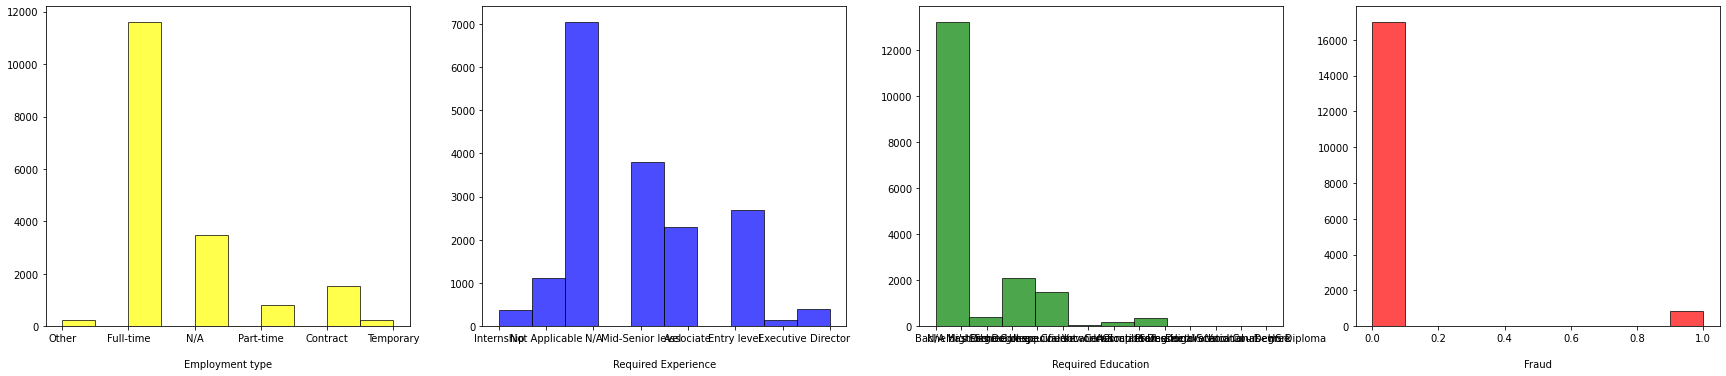

In [28]:
# visualize the data

plt.figure(figsize= (30,20))
plt.subplot(3,4,1)
plt.hist(data.employment_type, color='yellow', edgecolor = 'black', alpha = 0.7)
plt.xlabel('\nEmployment type')

plt.subplot(3,4,2)
plt.hist(data.required_experience, color='blue', edgecolor = 'black', alpha = 0.7)
plt.xlabel('\nRequired Experience')

plt.subplot(3,4,3)
plt.hist(data.required_education, color='green', edgecolor = 'black', alpha = 0.7)
plt.xlabel('\nRequired Education')

plt.subplot(3,4,4)
plt.hist(data.fraudulent, color='red', edgecolor = 'black', alpha = 0.7)
plt.xlabel('\nFraud')

Text(0.5, 0, 'industry')

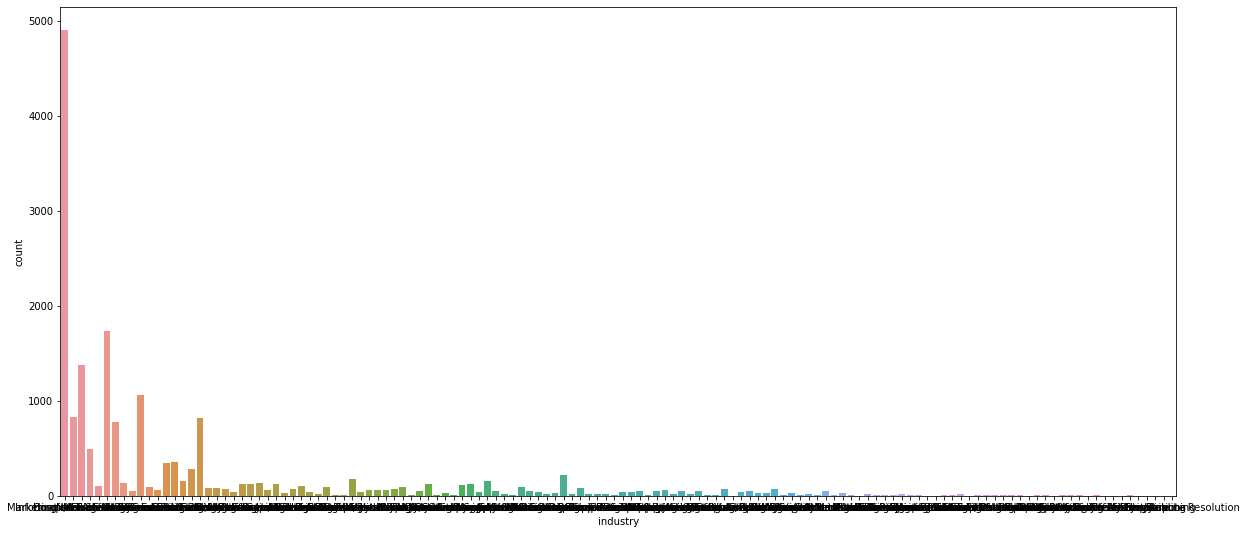

In [29]:
plt.figure(figsize = (20, 9))
sb.countplot(x = 'industry', data = data)
plt.xlabel('industry')

Text(0.5, 0, 'function')

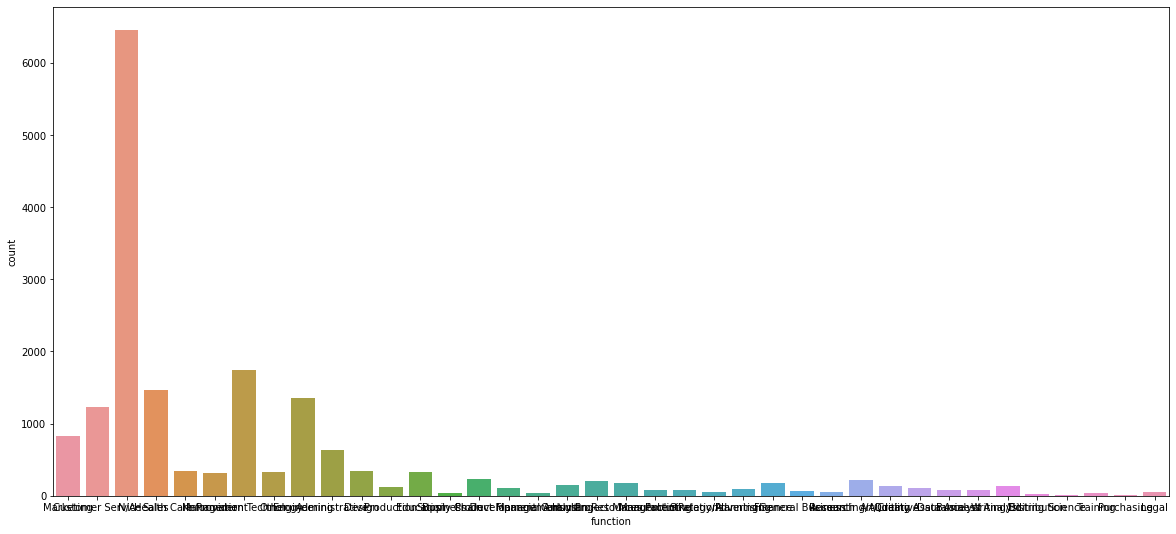

In [30]:
plt.figure(figsize = (20, 9))
sb.countplot(x = 'function', data = data)
plt.xlabel('function')

In [38]:
from nltk.stem.wordnet import WordNetLemmatizer
lmtzr = WordNetLemmatizer()

data["all_text"] = data["title"] + " " + data["department"] + " " + data["company_profile"] + " " 
+ data["description"] + " " + data["requirements"] + " " + data["benefits"] + " "
+ data["employment_type"] + " " + data["required_experience"] + " " 
+ data["required_education"] + " " + data["industry"] + " " + data["function"] + " " + data['country'] + ' '
+ data['state'] + " " + data['city']

data['all_text'] = [i.lower() for i in data['all_text']]
data['last_text'] = data['all_text'].apply(lambda x: ' '.join([lmtzr.lemmatize(word,'v') for word in x.split() ]))

stop_words = set(stopwords.words('english'))
data['last_text'] = data['last_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

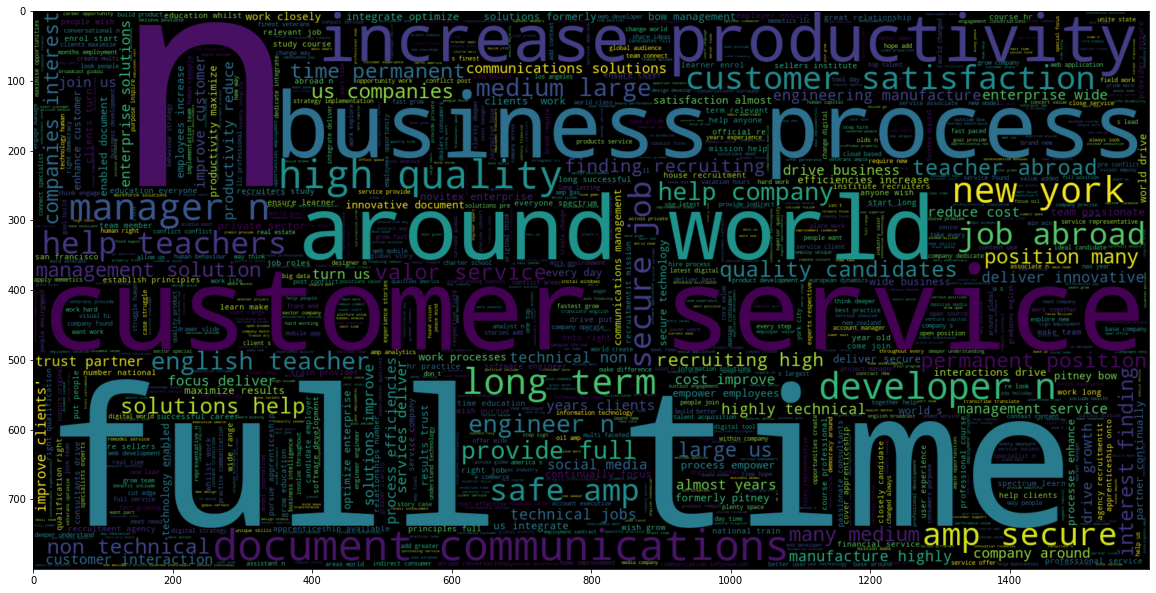

In [39]:
# visulization for words in non fraudulent
plt.figure(figsize = (20,20)) 
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(data[data.fraudulent == 0].last_text))
plt.imshow(wc , interpolation = 'bilinear')

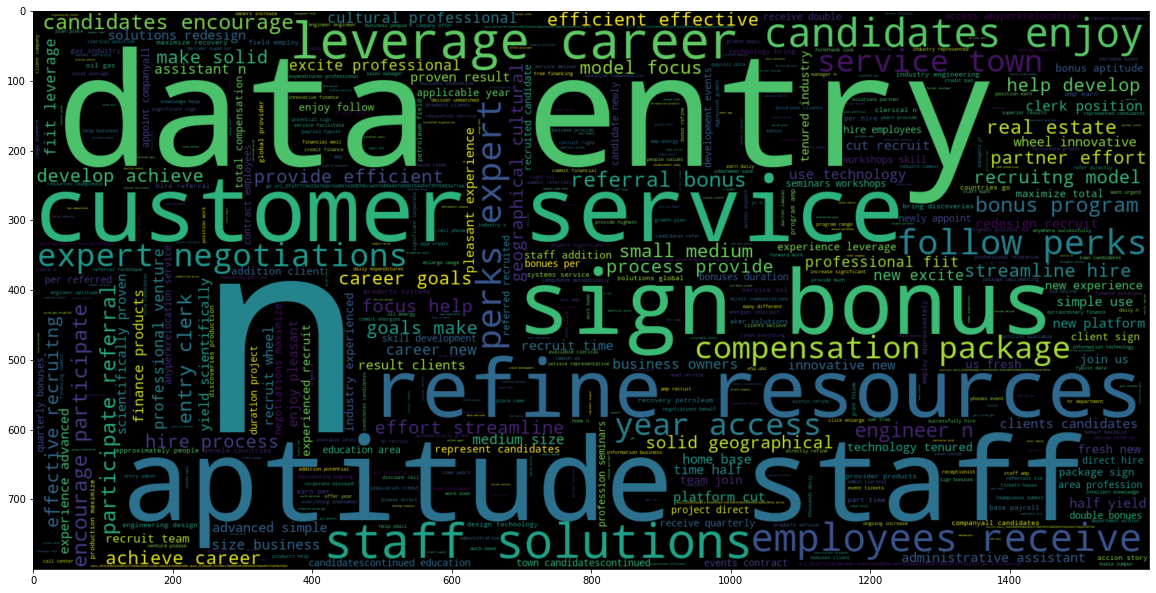

In [40]:
# visualize the words for fraudulent
plt.figure(figsize = (20,20)) 
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(data[data.fraudulent == 1].last_text))
plt.imshow(wc , interpolation = 'bilinear')

## tfidf rfr

In [15]:
# tokenizer define
ps = PorterStemmer()
stop = set(stopwords.words('english'))
def tokenizer (doc):
    sentences = sent_tokenize(doc)
    tokens = []
    for sent in sentences:
        words = word_tokenize(sent)
        words = [ps.stem(word) for word in words]
        tokens+=words
    return [w.lower() for w in tokens if w not in stop]

In [16]:
# combine text features and vectorize
df1 = data.copy()
text_feature = df1[['title', 'department','company_profile','description','requirements','benefits']].apply(lambda x: ' '.join(x), axis = 1)

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=True,
                        preprocessor=None,  # applied preprocessor in Data Cleaning
                        tokenizer=tokenizer,
                        use_idf=True,
                        norm='l2',
                        smooth_idf=True)

text_feature = tfidf.fit_transform(text_feature)

In [17]:
# encode label features
lb = LabelEncoder()

for col in ['employment_type', 'required_experience', 'required_education', 'industry', 'function', 'country',
       'state', 'city']:
    df1[col] = lb.fit_transform(df1[col])

In [18]:
# scale
label_feature = df1[['employment_type', 'required_experience', 'required_education', 'industry', 'function', 'country',
       'state', 'city']]
scaler = StandardScaler().fit(label_feature)

label_feature = scaler.transform(label_feature)

In [19]:
# build model
X = hstack((text_feature, label_feature))
y = df1['fraudulent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.10, random_state= 42, stratify= y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= 0.11, random_state= 42, stratify= y_train)


C:\Users\jiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
C:\Users\jiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you

In [23]:
rfr = RandomForestClassifier(class_weight = 'balanced', bootstrap = True)
rfr.fit(X_train, y_train)
score = cross_val_score(rfr, X_train, y_train)
score

C:\Users\jiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\jiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:489: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
C:\Users\jiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\tree\tree.py:163: De

array([0.97046502, 0.97235023, 0.97192541])

In [24]:
tfidf_pred = rfr.predict(X_test)
print(classification_report(y_test, tfidf_pred, target_names = ['0','1']))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1701
           1       0.98      0.46      0.62        87

    accuracy                           0.97      1788
   macro avg       0.97      0.73      0.81      1788
weighted avg       0.97      0.97      0.97      1788



C:\Users\jiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


## CountVectorize

In [42]:
# combine text features and vectorize
df2 = data.copy()
text_feature = df2[['title', 'department','company_profile','description','requirements','benefits']].apply(lambda x: ' '.join(x), axis = 1)

count = CountVectorizer(tokenizer=tokenizer)

text_feature = count.fit_transform(text_feature)

In [43]:
# encode label features
lb = LabelEncoder()

for col in ['employment_type', 'required_experience', 'required_education', 'industry', 'function', 'country',
       'state', 'city']:
    df2[col] = lb.fit_transform(df2[col])

In [44]:
# scale
label_feature = df2[['employment_type', 'required_experience', 'required_education', 'industry', 'function', 'country',
       'state', 'city']]
scaler = StandardScaler().fit(label_feature)

label_feature = scaler.transform(label_feature)

In [45]:
# build model
X = hstack((text_feature, label_feature))
y = df2['fraudulent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.10, random_state= 42, stratify= y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= 0.11, random_state= 42, stratify= y_train)

C:\Users\jiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
C:\Users\jiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you

In [46]:
rfr = RandomForestClassifier(class_weight = 'balanced', bootstrap = True)
rfr.fit(X_train, y_train)
score = cross_val_score(rfr, X_train, y_train)
score

C:\Users\jiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\jiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:489: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
C:\Users\jiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\tree\tree.py:163: De

array([0.9731881 , 0.97339757, 0.97464907])

In [47]:
count_pred = rfr.predict(X_test)
print(classification_report(y_test, tfidf_pred, target_names = ['0','1']))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1701
           1       0.98      0.46      0.62        87

    accuracy                           0.97      1788
   macro avg       0.97      0.73      0.81      1788
weighted avg       0.97      0.97      0.97      1788



C:\Users\jiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
